In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import numpy as np
import datetime
%matplotlib inline
plt.rcParams['font.family'] = ['SimHei'] #  set font for chinese in matplotlib figure

In [4]:
df_policy_raw = pd.read_csv('../Tbrain_Insurance/policy_claim/policy_0702.csv')
df_claim_raw = pd.read_csv('../Tbrain_Insurance/policy_claim/claim_0702.csv')
df_training_raw = pd.read_csv('../Tbrain_Insurance/training-set.csv')
df_testing_raw = pd.read_csv('../Tbrain_Insurance/testing-set.csv')
df_policy = df_policy_raw 
df_claim = df_claim_raw 
df_training = df_training_raw
df_testing = df_testing_raw
pd.set_option('display.max_columns', None)

# Policy

In [4]:
# Policy_Number	保單號碼 
# Insured's_ID	被保險人代號(替代值) 
# Prior_Policy_Number	前保單號     看 Cancellation & drop 掉
# Cancellation	非繼承自前保單  補成 0 & 1
# Vehicle_identifier	車牌號碼               # 算完ＩＤ擁有車輛數目後drop掉
# Vehicle_Make_and_Model1	廠牌名稱一  # drop 
# Vehicle_Make_and_Model2	廠牌名稱二  # drop
# Manafactured_Year_and_Month	製造年份  # 轉車齡
# Engine_Displacement_(Cubic_Centimeter)	排氣量 # drop 看重置成本
# Imported_or_Domestic_Car	車系代號 # dummy
# Coding_of_Vehicle_Branding_&_Type	廠牌車型代號 #drop
# qpt	乘載數量 # 保留值
# fpt	乘載單位  #drop
# Main_Insurance_Coverage_Group	險種分類  #dummy
# Insurance_Coverage	險種代碼 # dummy
# Insured_Amount1	保額一  # keep
# Insured_Amount2	保額二  # keep
# Insured_Amount3	保額三 # keep
# Coverage_Deductible_if_applied	自負額  # 展開成 (險種abc) x (比例, 數字) + 是否有負號
# Premium	簽單保費 # 分三險種加總 + total 4欄,
# Replacement_cost_of_insured_vehicle	重置成本
# Distribution_Channel	主通路代號  # 用Distribution_Channel跑單率替代
# Multiple_Products_with_TmNewa_(Yes_or_No?)	同一車主前一年度非車險保單件數 # keep
# lia_class	車責本期級數  # keep
# plia_acc	車責賠款係數  # +1 keep
# pdmg_acc	車體賠款係數  # +1 keep
# fassured	被保險人性質 # dummy
# ibirth	出生日期  # 轉年齡 自然人ＫＮＮ補 自然人drop
# fsex	性別  # 法人model drop
# fmarriage	婚姻狀況 # 同上
# aassured_zip	郵遞區號 # drop
# iply_area	承保地區代號(分公司)  #dummy
# dbirth	要保人出生日期  # 同出生日期
# fequipment1	配備-音響註記  #dummy
# fequipment2	配備-車箱註記  #dummy
# fequipment3	配備-冷凍機組註記  #dummy
# fequipment4	配備-車框、車斗註記  # drop
# fequipment5	配備-昇降系統註記  #dummy
# fequipment6	配備-電動車電池註記 # drop
# fequipment9	配備-其他  #dummy
# nequipment9	配備-其他說明 #dummy blank->.0  not blank -> 1
##################################### 生feature
# Insured's_ID有幾輛車
# Insured's_ID有張保單
# Insured's_ID 車責 竊盜 車損 單數的 sum, mean, std
# Main_Insurance_Coverage_Group count
# Insurance_Coverage count
# sum, std, mean
# Insured_Amount1_車責 Insured_Amount1_竊盜 Insured_Amount1_車損
# Insured_Amount2 同上
# Insured_Amount3 同上
# (Insured_Amount1 + Insured_Amount2 + Insured_Amount3) * 3 (Insurance_Coverage)
# 3險種  total 保額  / total 保費
# total保費 / 重置成本
# Distribution_Channel 跑單率
# lia_class 係數轉換表 (x-4) * 0.1 + 1
# fequipment1~fequipment9, nequipment9 sum != 0

In [27]:
# df_policy.iloc[:1000,:].groupby(['Policy_Number', 'Prior_Policy_Number'])['Insured\'s_ID'].unique()
df_policy.iloc[:1000,:].groupby(['Policy_Number', 'Prior_Policy_Number', 'Insured\'s_ID']).Vehicle_identifier.nunique().value_counts()

1    119
Name: Vehicle_identifier, dtype: int64

In [18]:
df_policy[df_policy.Policy_Number == '04ad40d5b2d9e743efaf5ae062f4f7a44b31982b']

,Policy_Number,Insured's_ID,Prior_Policy_Number,Cancellation,Vehicle_identifier,Vehicle_Make_and_Model1,Vehicle_Make_and_Model2,Manafactured_Year_and_Month,Engine_Displacement_(Cubic_Centimeter),Imported_or_Domestic_Car,Coding_of_Vehicle_Branding_&_Type,qpt,fpt,Main_Insurance_Coverage_Group,Insurance_Coverage,Insured_Amount1,Insured_Amount2,Insured_Amount3,Coverage_Deductible_if_applied,Premium,Replacement_cost_of_insured_vehicle,Distribution_Channel,Multiple_Products_with_TmNewa_(Yes_or_No?),lia_class,plia_acc,pdmg_acc,fassured,ibirth,fsex,fmarriage,aassured_zip,iply_area,dbirth,fequipment1,fequipment2,fequipment3,fequipment4,fequipment5,fequipment6,fequipment9,nequipment9
599,04ad40d5b2d9e743efaf5ae062f4f7a44b31982b,2705f5fdc2ba60cbb866e7ae9f08779016d87cadf,78e620377a5a1e977bc173b7d8cdf1f34cda4af5,,79bd5b42604d2ae90905f40c7d018930f06500af,960d139497003852038c328303d92f423e6854c4,d329495b2f0cd9df3c1244015416d0ee40e0e684,2004,1997,10,1536cc26cacd8d56c9b40aca8f8f9714fff5eed1,5.0,P,車損,04M,0,0,49000,0,2217,53.5,52ee862de32ba73e341b7c6be241b00d4a5c23ee,15.0,-1,-0.38,-0.6,2,NaN,,,ecb7937db58ec9dea0c47db88463d85e81143032,356a192b7913b04c54574d18c28d46e6395428ab,NaN,0,0,0,0,0,0,0,
600,04ad40d5b2d9e743efaf5ae062f4f7a44b31982b,2705f5fdc2ba60cbb866e7ae9f08779016d87cadf,78e620377a5a1e977bc173b7d8cdf1f34cda4af5,,79bd5b42604d2ae90905f40c7d018930f06500af,960d139497003852038c328303d92f423e6854c4,d329495b2f0cd9df3c1244015416d0ee40e0e684,2004,1997,10,1536cc26cacd8d56c9b40aca8f8f9714fff5eed1,5.0,P,竊盜,05N,0,0,49000,10,92,53.5,52ee862de32ba73e341b7c6be241b00d4a5c23ee,15.0,-1,-0.38,-0.6,2,NaN,,,ecb7937db58ec9dea0c47db88463d85e81143032,356a192b7913b04c54574d18c28d46e6395428ab,NaN,0,0,0,0,0,0,0,
601,04ad40d5b2d9e743efaf5ae062f4f7a44b31982b,2705f5fdc2ba60cbb866e7ae9f08779016d87cadf,78e620377a5a1e977bc173b7d8cdf1f34cda4af5,,79bd5b42604d2ae90905f40c7d018930f06500af,960d139497003852038c328303d92f423e6854c4,d329495b2f0cd9df3c1244015416d0ee40e0e684,2004,1997,10,1536cc26cacd8d56c9b40aca8f8f9714fff5eed1,5.0,P,車責,16G,4000000,0,8000000,0,1505,53.5,52ee862de32ba73e341b7c6be241b00d4a5c23ee,15.0,-1,-0.38,-0.6,2,NaN,,,ecb7937db58ec9dea0c47db88463d85e81143032,356a192b7913b04c54574d18c28d46e6395428ab,NaN,0,0,0,0,0,0,0,
602,04ad40d5b2d9e743efaf5ae062f4f7a44b31982b,2705f5fdc2ba60cbb866e7ae9f08779016d87cadf,78e620377a5a1e977bc173b7d8cdf1f34cda4af5,,79bd5b42604d2ae90905f40c7d018930f06500af,960d139497003852038c328303d92f423e6854c4,d329495b2f0cd9df3c1244015416d0ee40e0e684,2004,1997,10,1536cc26cacd8d56c9b40aca8f8f9714fff5eed1,5.0,P,車責,16P,0,0,1000000,0,1266,53.5,52ee862de32ba73e341b7c6be241b00d4a5c23ee,15.0,-1,-0.38,-0.6,2,NaN,,,ecb7937db58ec9dea0c47db88463d85e81143032,356a192b7913b04c54574d18c28d46e6395428ab,NaN,0,0,0,0,0,0,0,
603,04ad40d5b2d9e743efaf5ae062f4f7a44b31982b,2705f5fdc2ba60cbb866e7ae9f08779016d87cadf,78e620377a5a1e977bc173b7d8cdf1f34cda4af5,,79bd5b42604d2ae90905f40c7d018930f06500af,960d139497003852038c328303d92f423e6854c4,d329495b2f0cd9df3c1244015416d0ee40e0e684,2004,1997,10,1536cc26cacd8d56c9b40aca8f8f9714fff5eed1,5.0,P,車責,29B,0,5000000,20000000,0,992,53.5,52ee862de32ba73e341b7c6be241b00d4a5c23ee,15.0,-1,-0.38,-0.6,2,NaN,,,ecb7937db58ec9dea0c47db88463d85e81143032,356a192b7913b04c54574d18c28d46e6395428ab,NaN,0,0,0,0,0,0,0,
604,04ad40d5b2d9e743efaf5ae062f4f7a44b31982b,2705f5fdc2ba60cbb866e7ae9f08779016d87cadf,78e620377a5a1e977bc173b7d8cdf1f34cda4af5,,79bd5b42604d2ae90905f40c7d018930f06500af,960d139497003852038c328303d92f423e6854c4,d329495b2f0cd9df3c1244015416d0ee40e0e684,2004,1997,10,1536cc26cacd8d56c9b40aca8f8f9714fff5eed1,5.0,P,車責,29K,0,0,5000000,0,790,53.5,52ee862de32ba73e341b7c6be241b00d4a5c23ee,15.0,-1,-0.38,-0.6,2,NaN,,,ecb7937db58ec9dea0c47db88463d85e81143032,356a192b7913b04c54574d18c28d46e6395428ab,NaN,0,0,0,0,0,0,0,


In [1]:
# Policy NAN column
# Prior_Policy_Number    328557  相當於cancellation（Y,N） , drop
# Vehicle_identifier           513        #  drop: Insured ID算車牌個數 
# ibirth                              317765  # 自然人KNN補  法人不補 分model補  optional: age group
# dbirth                            258932   # 自然人KNN補  法人補成NAN 分model補  optional: age group
# fsex                               41945 # 法人補成NAN
# fmarriage                      41945 # 法人補成NAN


In [20]:
cond = (df_policy.fassured == 2) | (df_policy.fassured == 4)
df_fa = df_policy[cond]
df_policy[cond]['fmarriage'].value_counts(), df_policy[cond]['fmarriage'].isnull().sum()

(     275814
 1        12
 Name: fmarriage, dtype: int64, 41945)

In [17]:
df_policy[cond]['dbirth'].isnull().value_counts()

True     253746
False     64025
Name: dbirth, dtype: int64

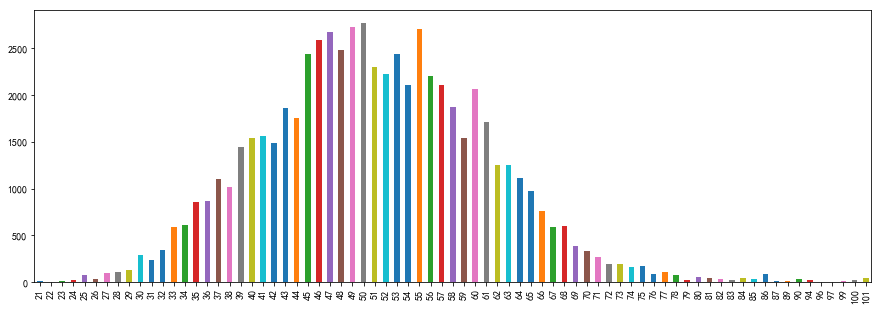

In [37]:
df_fa[pd.to_datetime(df_fa.dbirth, format='%m/%Y', errors='coerce').isnull() == False]
df_fa_not_null = df_fa[pd.to_datetime(df_fa.dbirth, format='%m/%Y', errors='coerce').isnull() == False]
plt.figure(figsize=(15,5))
(2016 - pd.to_datetime(df_fa_not_null.dbirth, format='%m/%Y', errors='coerce').dt.year).value_counts().sort_index().plot.bar()

In [44]:
df_fa_not_null[['Premium', 'dbirth']]
df_policy['dbirth'] = (2016 - pd.to_datetime(df_fa_not_null.dbirth, format='%m/%Y', errors='coerce').dt.year)
# df_policy[df_policy.dbirth.isnull() == False][['Premium', 'dbirth']]
df_policy[['Premium', 'dbirth']]

,Premium,dbirth
0,1551,NaN
1,1163,NaN
2,2031,NaN
3,1098,NaN
4,149,NaN
5,1289,NaN
6,1846,NaN
7,183,NaN
8,184,NaN
9,70,NaN
